# Import Libraries

Zuerst binden wir wie immer die Benutzen Bibliotheken ein.

In [1]:
from netgen.geom2d import *
import scipy
import scipy.sparse.linalg
import outsource
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import unitary_group
from ngsolve import *
from ngsolve.webgui import Draw

# Implemented QR-Algorithm

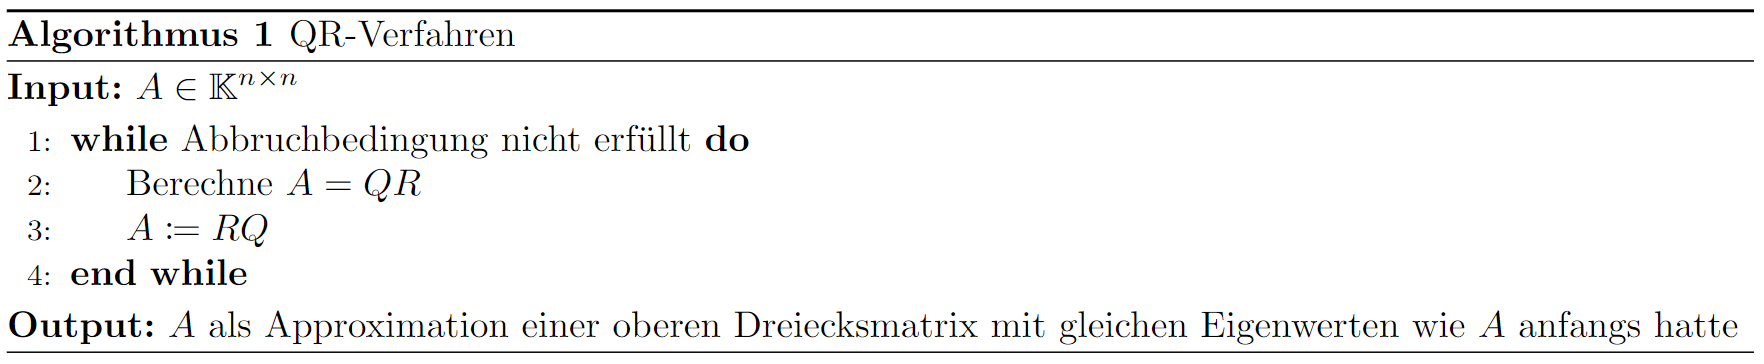


Diese simple Version ist schnell implementiert. Zur Fehler- und Laufzeittestung kommen wir am Ende des Abschnitts.

In [2]:
def QR_simple(A,tol = 1e-10):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):                   #i durchläuft {1,...,n} rückwärts 
        while abs(A[i,i-1]) > tol:              #in der Zeile ist immer labmda_i/lambda_{i-1} am größten
            Q,R = np.linalg.qr(A)               #QR-Zerlegung der  Matrix
            A = R@Q                             #RQ
            count +=1
        A[i,:i-n] = 0                           #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count             

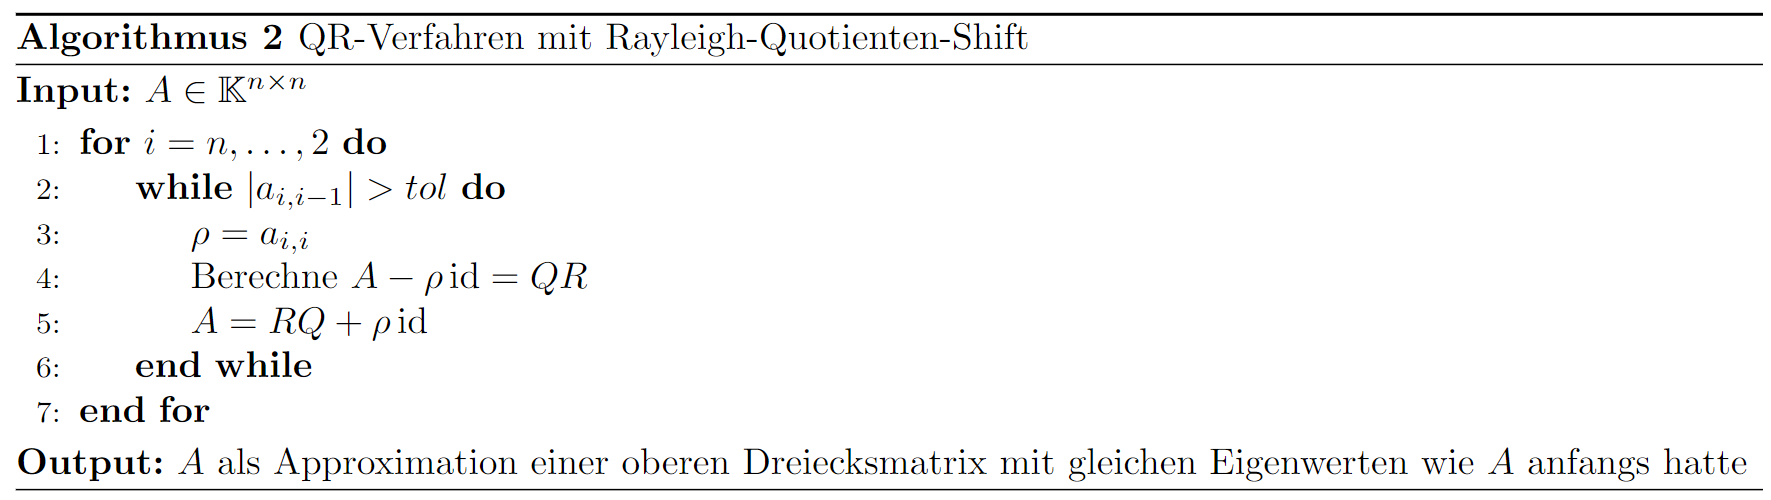

In [3]:
def QR_shift(A,tol=1e-10):
    n = A.shape[1]                                    #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                         #i durchläuft {1,...,n} rückwärts 
        while abs(A[i,i-1]) > tol:                    #in der Zeile ist immer labmda_i/lambda_{i-1} am größten
            rho = A[i,i]                              #Der Shift-Parameter
            Q,R = np.linalg.qr(A-rho*np.identity(n))  #QR-Zerlegung der geshifteten Matrix
            A = R@Q + rho*np.identity(n)              #RQ + Rückshift
            count +=1
        A[i,:i-n] = 0                                 #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count

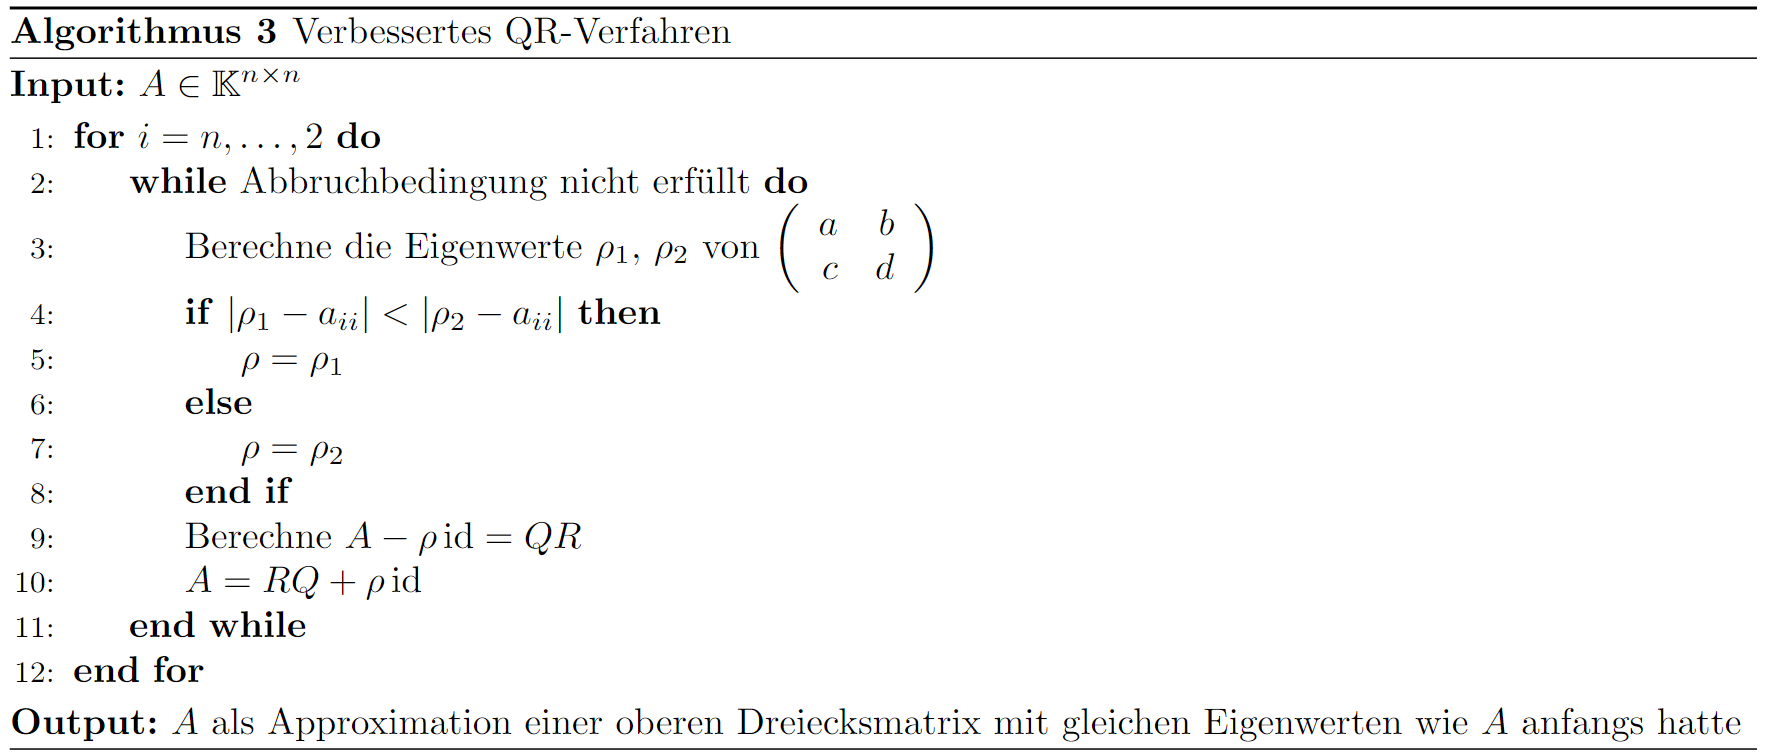

In [4]:
def QR_shift2(A,tol=1e-14):
    n = A.shape[1]                                                #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                                     #i durchläuft {1,...,n} rückwärts
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):  #Hier ein kleiner Fehler im Skript
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])             #Eigenwerte werden berechnet
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):           #Es wird überprüft, welcher der Eigenwerte näher am Diagonalelement ist
                rho = w[0]                                        #Wahl für den shift, falls 1 Eigenwert näher am Diagonalelement
            else:
                rho = w[1]                                        #Wahl für den shift, falls 2 Eigenwert näher am Diagonalelement
            Q,R = np.linalg.qr(A-rho*np.identity(n))              #QR-Zerlegung der geshifteten Matrix
            A = R@Q + rho*np.identity(n)                          #RQ + Rückshift
            count += 1
        A[i,:i-n] = 0                                             #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count

In [5]:
n_arr = [10*i for i in range(1,9)]                                 #Dimension des Problems

k = len(n_arr)
eigv_array = []
for i in range(k):
    eigv_array.append(np.sort(5000*np.random.rand(n_arr[i])-250)) #Eigenwerte werden zufällig generiert

In [6]:
mat_array = []

for i in range(k):
    mat_array.append(outsource.gen_rand_mat(eigv_array[i]))

In [7]:
time_1 = [0]*k
time_2 = [0]*k
time_3 = [0]*k

error_1 = [0]*k
error_2 = [0]*k
error_3 = [0]*k
for i in range(k):
    time_1[i], error_1[i] = outsource.runtime_error(QR_simple, mat_array[i], eigv_array[i])
    time_2[i], error_2[i] = outsource.runtime_error(QR_shift, mat_array[i], eigv_array[i])
    time_3[i], error_3[i] = outsource.runtime_error(QR_shift2, mat_array[i], eigv_array[i])

<IPython.core.display.Javascript object>


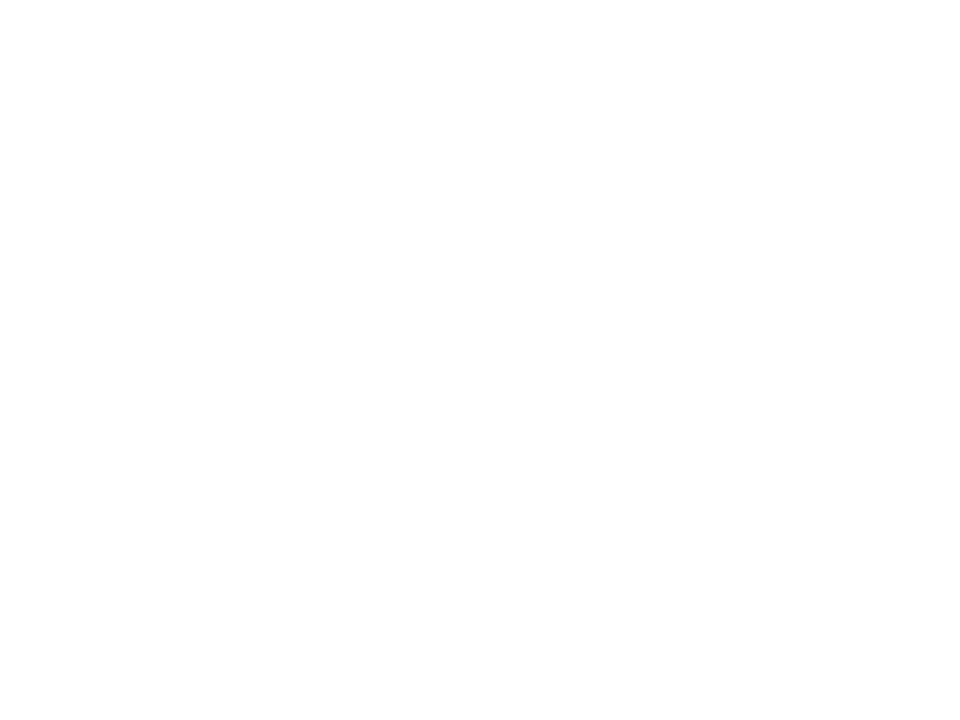

In [8]:
%matplotlib notebook

plt.plot(n_arr, time_1, '-o', label = "Anzahl an Schleifendurchläufen ohne shifts")
plt.plot(n_arr, time_2, '-o', label = "Anzahl an Schleifendurchläufen mit Rayleigh-Quotienten-Shift")
plt.plot(n_arr, time_3, '-o', label = "Anzahl an Schleifendurchläufen mit Wilkinson-Shift")

plt.ylabel("Schleifendurchläufe")
plt.xlabel("$n$")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


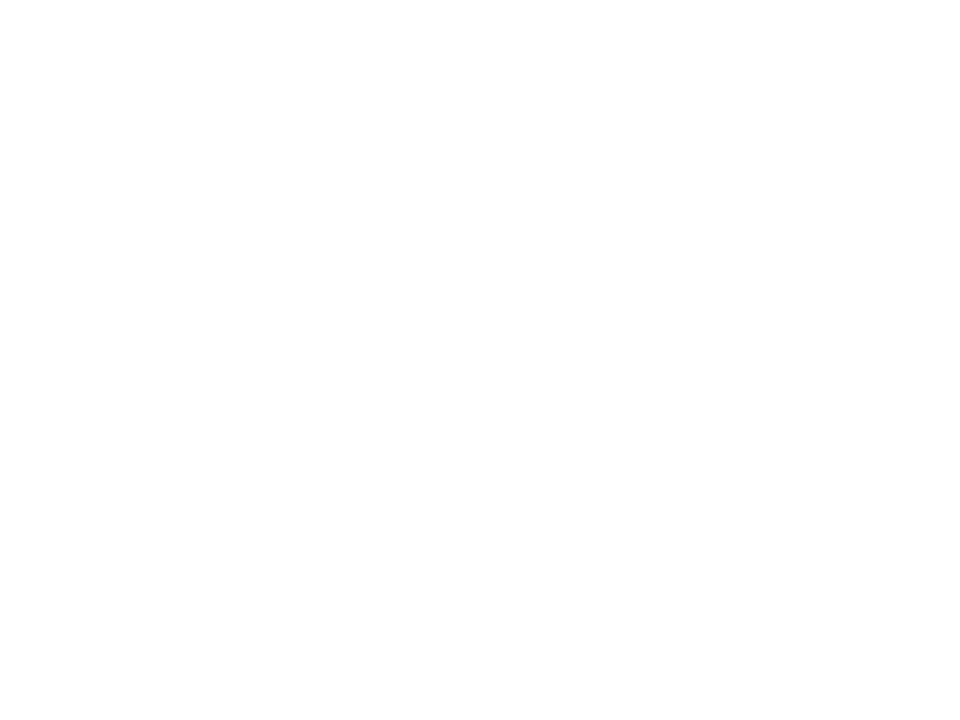

In [9]:
%matplotlib notebook

plt.semilogy(n_arr, error_1, '-o', label = "Fehler ohne shifts")
plt.semilogy(n_arr, error_2, '-o', label = "Fehler mit Rayleigh-Quotienten-Shift")
plt.semilogy(n_arr, error_3, '-o', label = "Fehler mit Wilkinson-Shift")

plt.ylabel("Error")
plt.xlabel("$n$")
plt.legend()
plt.show()

In [10]:
n_shifts = [10*i for i in range(1,25)]

len_shifts = len(n_shifts)

In [11]:
eigv_array_shifts = []
for i in range(len_shifts):
    eigv_array_shifts.append(np.sort(5000*np.random.rand(n_shifts[i])-250)) #Eigenwerte werden zufällig generiert

In [12]:
mat_array_shifts = []

for i in range(len_shifts):
    mat_array_shifts.append(outsource.gen_rand_mat(eigv_array_shifts[i]))

In [13]:
time_shifts1 = [0]*len_shifts
time_shifts2 = [0]*len_shifts

error_shifts1 = [0]*len_shifts
error_shifts2 = [0]*len_shifts

for i in range(len_shifts):
    time_shifts1[i], error_shifts1[i] = outsource.runtime_error(QR_shift, mat_array_shifts[i], eigv_array_shifts[i])
    time_shifts2[i], error_shifts2[i] = outsource.runtime_error(QR_shift2, mat_array_shifts[i], eigv_array_shifts[i])

<IPython.core.display.Javascript object>


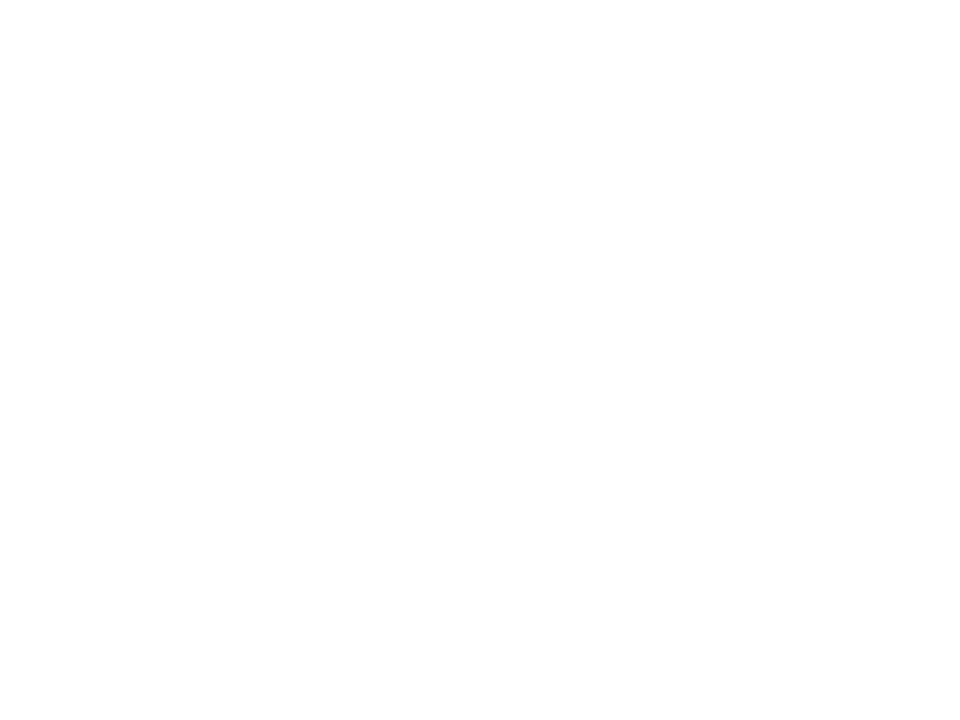

In [14]:
%matplotlib notebook

plt.plot(n_shifts, time_shifts1, 'o', label = "Anzahl an Schleifendurchläufen mit Rayleigh-Quotienten-Shift")
plt.plot(n_shifts, time_shifts2, 'o', label = "Anzahl an Schleifendurchläufen mit Wilkinson-Shift")

plt.ylabel("Schleifendurchläufe")
plt.xlabel("$n$")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


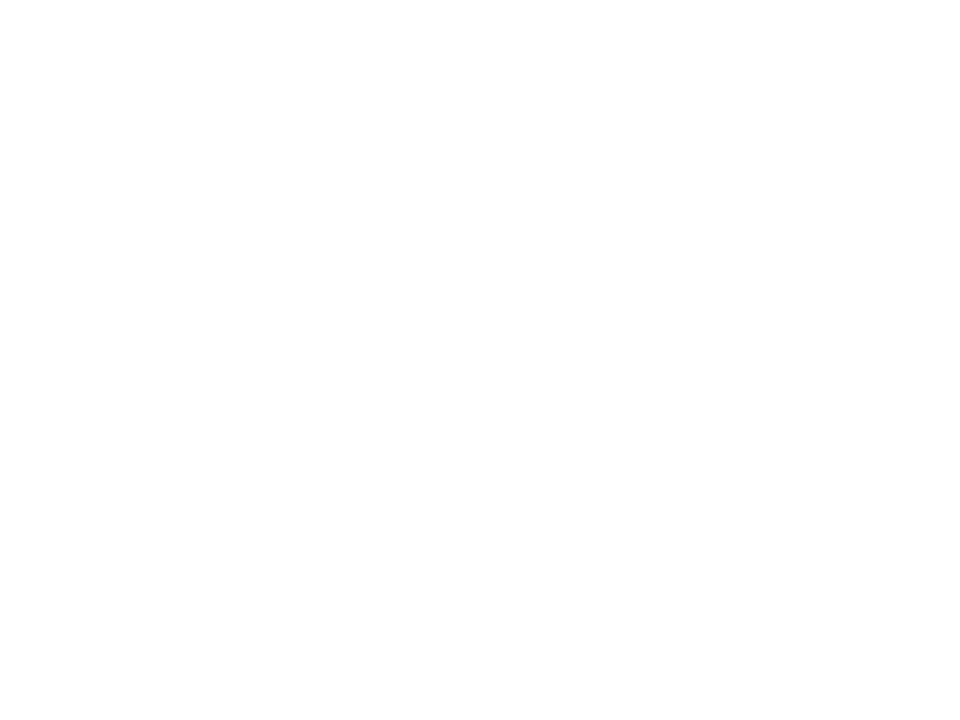

In [15]:
%matplotlib notebook

plt.semilogy(n_shifts, error_shifts1, '-o', label = "Fehler mit Rayleigh-Quotienten-Shift")
plt.semilogy(n_shifts, error_shifts2, '-o', label = "Fehler mit Wilkinson-Shift")

plt.ylabel("Error")
plt.xlabel("$n$")
plt.legend()
plt.show()

## Special-Case: QR-Algorithm applied to a Hessenberg-Matrix

Hier können wir Givens-Rotation verwenden um die QR-Zerlegung durchzufühern und einen speed-up zu bekommen. Als Givens-Rotation bezeichnet man eine $n \times n$ Matrix der Form

$$
G(j,k,c,s)  = \left(\begin{array}{ccc|ccccc|ccc}
    1 &  &  & & & & & & &\\
    & \ddots & & & & & & & & &\\
    & & 1 & & & & & & & \\
    \hline
    & & &  \overline{c} & & & & \overline{s} & & &\\
    & & & & 1 & & & & & &\\
    & & & & & \ddots & & & & &\\
    & & & & &  &1 & & & &\\
    & & & -s & & & & c & & &\\
    \hline
    & & & & & & & & 1 & &\\
    & & & & & & & & & \ddots &\\
    & & & & & & & & & & 1\\
    \end{array}\right)
$$

mit $|c|^2 + |s|^2 = 1$. Der innere Block reicht dabei von der $j$-ten bis zur $k$-ten Zeile sowie Spalte.
Givens-Rotationen sind unitär, da 

$$
\left(\begin{array}{cc}
\overline{c}& \overline{s} \\
-s & c\\
\end{array}\right)\left(\begin{array}{cc}
c & -\overline{s} \\
s & \overline{c}
\end{array}\right)
=
\left(\begin{array}{cc}
|c|^2 + |s|^2 & 0 \\
0 & |c|^2 + |s|^2 \\
\end{array}\right)$$

Wir werden es mit Givens-Rotationen der Form

$$
G(j,j+1,c,s) =
    \left(\begin{array}{ccc|cc|ccc}
    1 & & & & & & & \\
    & \ddots & & & & & & \\
    & & 1 & & & & & \\
    \hline
    & & & \overline{c} & \overline{s} & & & \\
    & & & -s & c & & &\\
    \hline
    & & & & & 1 & & \\
    & & & & & & \ddots & \\
    & & & & & & & 1\\
    \end{array}\right)
$$

zu tun haben.

Multiplikation einer Givens-Rotation der obigen Form von links an eine Matrix $A\in \mathbb{K}^{n\times n}$ hat dann nur in der $j$-ten sowie $j+1$-ten Zeile von $A$ eine Auswirkung. Dort werden die Einträge $a_{j,k}$ sowie $a_{j+1, k}$ ersetzt durch $a_{j,k}\overline{c} + a_{j+1, k}\overline{s}$ bzw. $-a_{j,k}s + a_{j+1, k}c$. Dies können wir nun dazu verwenden um bei einer Hessenberg-Matrix die Einträge unter der Diagonale zu eliminieren und dadurch eine obere Dreiecksmatrix erhalten. 

Dazu müssen wir die Gleichung $-a_{j,j}s + a_{j+1, j}c = 0$ unter der Nebenbedingung $|c|^2 + |s|^2 = 1$ lösen. Die beiden Lösungen unterscheiden sich, wie man sich leicht überzeugen kann, nur durch das Vorzeichen. Eine Lösung ist gegeben durch

$$\left(\begin{array}{c}
    c \\
    s \\
\end{array}\right)
=
\frac{1}{\sqrt{|a_{j,j}|^2 + |a_{j+1,j}|^2}}
\left(\begin{array}{c}
a_{j,j} \\
a_{j+1,j} \\
\end{array}\right)
$$

Um einen over- oder underflow zu vermeiden werden wir jedoch eine andere äquivalente Formel verwenden.

Eine Hessenberg-Matrix $A \in \mathbb{K}^{n\times n}$ können wir dann durch Anwendung von $n-1$ Givens-Rotationen auf eine obere Dreiecksmatrix bringen. Folgende Darstellung aus dem Numerik-Skriptum beschreibt die Vorgehensweise bei $n = 4$:

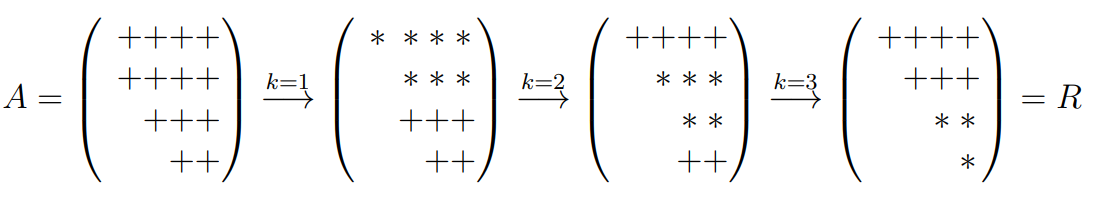

Die spezielle Struktur der Hessenberg-Matrix können wir nun verwenden, um Rechenschritte zu sparen: In der $j$-ten Zeile sind die ersten $j-2$ Einträge bereits $0$ (und damit auch in der $j+1$-ten Zeile). Daher müssen wir die Anwendung der Givens-Rotation erst ab der $j-1$-ten Spalte realisieren.

Um schließlich noch die $Q$-Matrix aus der QR-Zerlegung zu erhalten, bemerken wir zunächst, dass die Multiplikation zweier unitärer Matrizen wieder eine unitäre Matrix liefert. Durch unseren Algorithmus erhalten wir

$$
R = G(n-1,n,c_{n-1},s_{n-1})\cdots G(1,2, c_1, s_1) A
$$

Die Multiplikaton der Givens-Rotationen gibt wieder eine unitäre Matrix, definieren wir also 

$$
\overline{Q}^\top := G(n-1,n,c_{n-1},s_{n-1})\cdots G(1,2, c_1, s_1)
$$

erhalten wir $Q$ durch transponieren und konjugieren des Produktes der Givens-Rotationen, da dann

$$
QR = A
$$

Bei Multiplikation der $l+1$-ten Givens-Rotation mit dem Produkt der $l$ vorhergegangenen können wir wieder verwenden, dass nur in zwei Zeilen eine Änderung passiert. Da das Produkt der Givens-Rotationen jedoch keine Hessenberg-Matrix ist, müssen wir die Rechnung in allen Spalten durchführen.

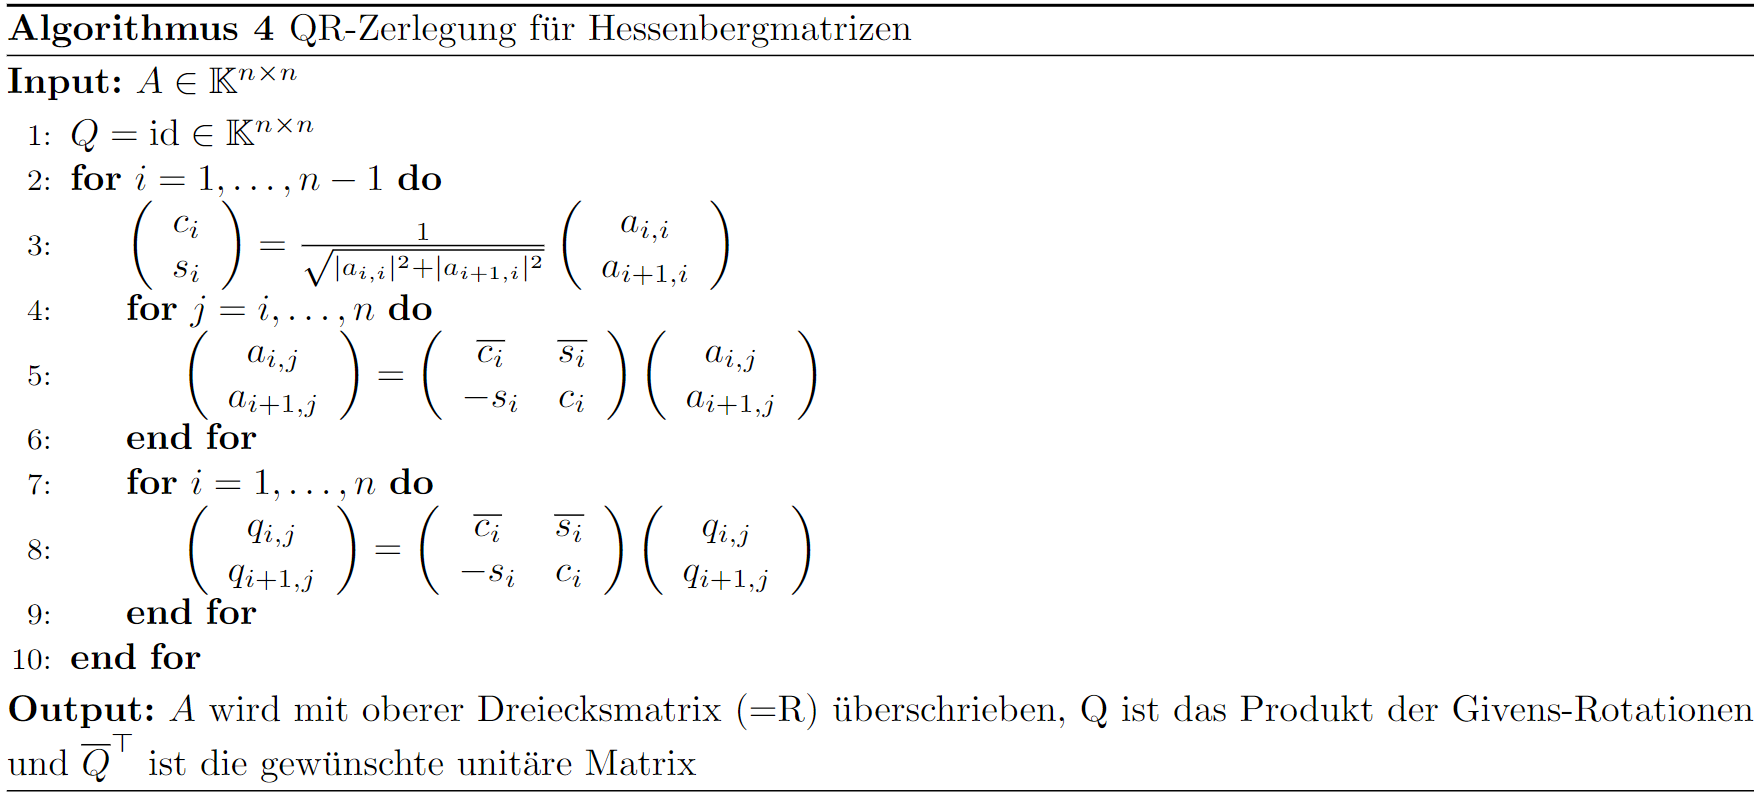

In [16]:
def QR_decomp_hesse(A):
    n = A.shape[0]
    Q = np.eye(n,n)

    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):                     #Überprüfen der Bedingung
            t = A[i+1,i]/abs(A[i,i])                         #Berechnung von t
            root = (1+abs(t)**2)**(1/2)                      #Ausdruck in der Wurzel
            c = A[i,i]/(abs(A[i,i])*root)                    #Berechnung von c
            s = t/root                                       #Berechnung von s
        else:
            t = A[i,i]/abs(A[i+1,i])                         #Berechnung von t
            root = (1+abs(t)**2)**(1/2)                      #Ausdruck in der Wurzel
            s = A[i+1,i]/(abs(A[i+1,i])*root)                #Berechnung von s
            c = t/root                                       #Berechnung von c
            
        for j in range(n):
            if j < i:                                        #Bis zum i-ten Index sind die Einträge a_{i,j} sowie a_{i+1,j} 0
                temp_2 = Q[i,j]                              #Zwischenspeichern des Eintrags, da dieser im nächsten Schritt überschireben wird
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j] #Berechnung des neuen Eintrags    
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]            #Berechnung des neuen Eintrags
            else:
                temp_1 = A[i,j]                              #Zwischenspeichern des Eintrags, da dieser im nächsten Schritt überschireben wird
                A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j] #Berechnung der neuen Einträge  
                A[i+1,j] = -s*temp_1 + c*A[i+1,j]   
                temp_2 = Q[i,j]
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j]     
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]                                
            
    return Q.T.conj(), A

In [17]:
def QR_hesse(A,tol=1e-14):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = QR_decomp_hesse(A-rho*np.identity(n))            #Statt vorimplementierter QR-Zerlegung hier QR-Zerlegung mit Givens-Rotationen
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count

Wir können nun auch Vergleichen.

In [18]:
n_arr_1 = [10*i for i in range(1,20)]       #Dimension des Problems

k = len(n_arr_1)
    
mat_array_1 = []

for i in range(k):
    mat_array_1.append(outsource.gen_hess(n_arr_1[i])) #Hesseberg-Matrizen der Dimension n werden erstellt

In [19]:
time_givens = [0]*k
time_vorimplementiert = [0]*k

for i in range(k):
    time_givens[i] = outsource.runtime(QR_decomp_hesse, mat_array_1[i])
    time_vorimplementiert[i] = outsource.runtime(np.linalg.qr, mat_array_1[i])

<IPython.core.display.Javascript object>


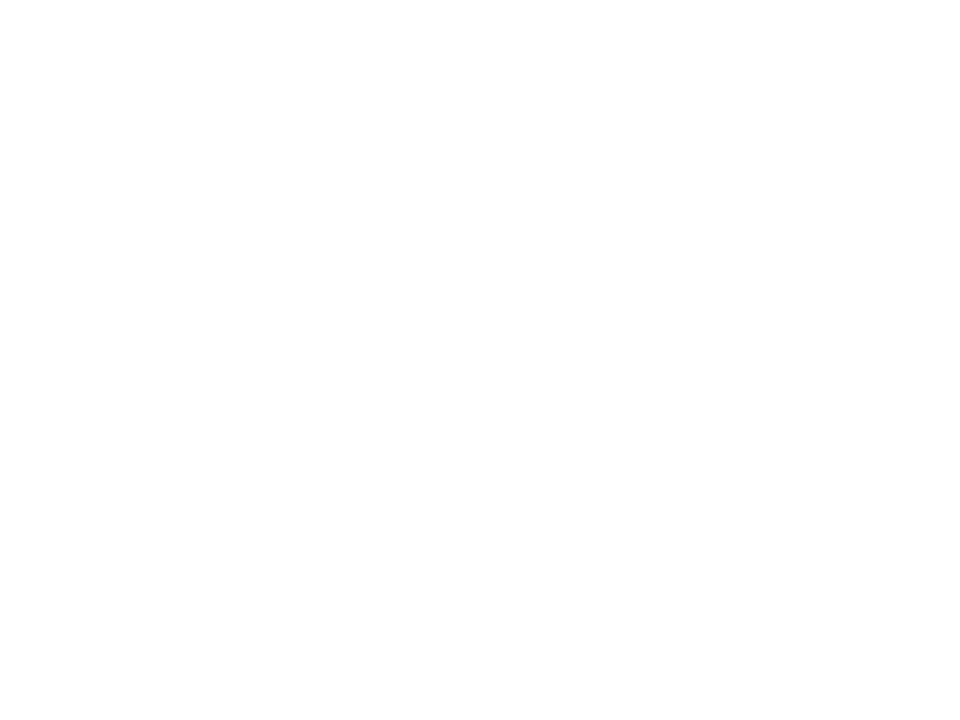

In [20]:
%matplotlib notebook

plt.plot(n_arr_1, time_givens, '-o', label = "QR-Zerlegung mit Givens-Rotationen")
plt.plot(n_arr_1, time_vorimplementiert, '-o', label = "QR-Zerlegung Vorimplemeniert")

plt.xlabel("n")
plt.ylabel("time")
plt.legend()
plt.show()

Wie man erkennt ist der Vorimplementierte QR-Algorithmus wohl immer noch um einiges effizienter.

QR an nicht-Hesseberg im Vergleich zu QR-Hesse an Hesseberg.


In [21]:
mat_array_2 = []


for i in range(k):
    mat_array_2.append(outsource.gen_rand_mat(500*np.random.rand(n_arr_1[i])))

In [22]:
time_givens_1 = [0]*k
time_vorimplementiert_1 = [0]*k

for i in range(k):
    time_givens_1[i] = outsource.runtime(QR_decomp_hesse, mat_array_1[i])
    time_vorimplementiert_1[i] = outsource.runtime(np.linalg.qr, mat_array_2[i])

In [23]:
%matplotlib notebook

plt.plot(n_arr_1, time_givens_1, '-o', label = "QR-Zerlegung mit Givens-Rotationen")
plt.plot(n_arr_1, time_vorimplementiert_1, '-o', label = "QR-Zerlegung Vorimplementiert an allgemeiner Matrix")

plt.xlabel("n")
plt.ylabel("time")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

## Lanczos-Algorithm

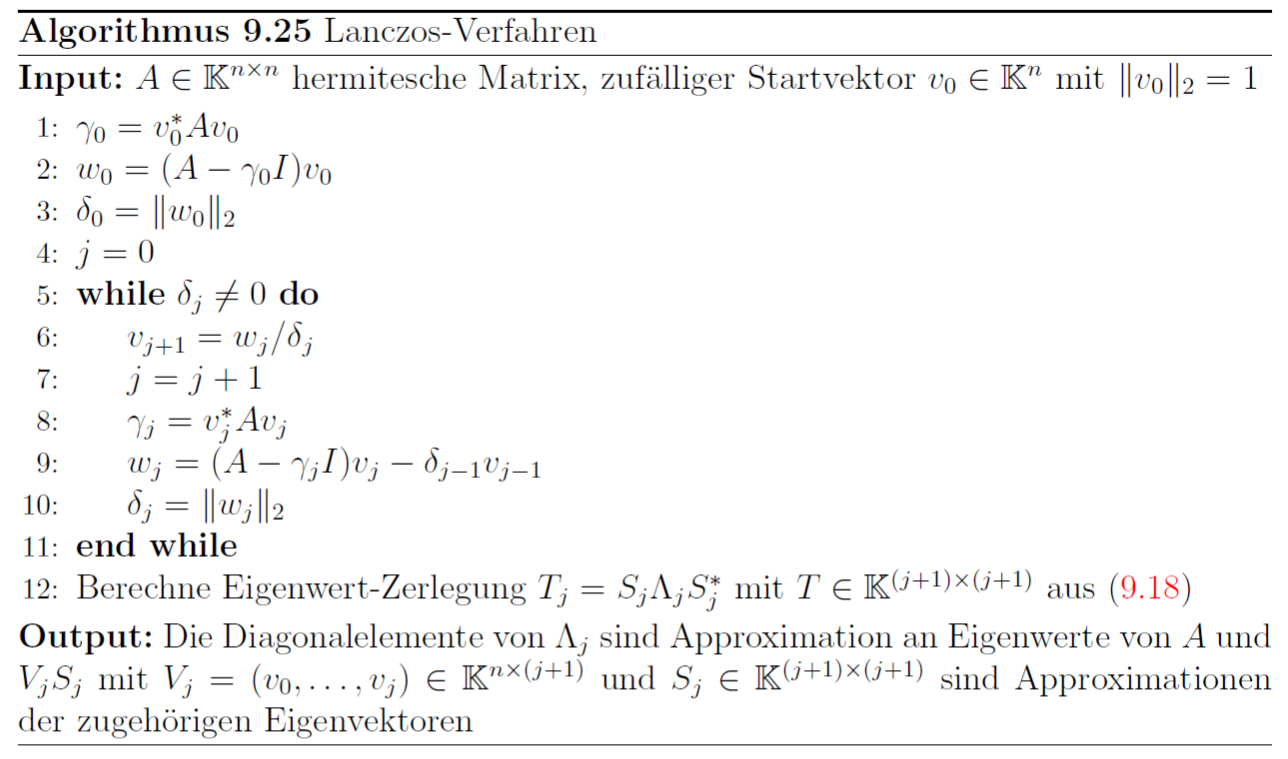

In [29]:
def lanczos(A,m = 0):                                                  #m sei die Anzahl der zu berechnenden Eigenwerte
    n = A.shape[1]
    if m == 0:                                                         #Wird keine Anzahl angegeben werden alle berechnet
        m = n
        
    v0 = np.random.rand(n)                                             #Randomisierter Startvektor wird gewählt
    v = [v0/np.linalg.norm(v0)]                                        #Normieren sowie Listenerstellung
    gam = [v[0].T.conj()@A@v[0]]                                       #Berechnung von gamma und Listenerstellung
    w = (A - gam[0]*np.identity(n))@v[0]                               #Berechnung des Vektors w
    delta = [np.linalg.norm(w)]                                        #Zugehörige Norm sowie Listenerstellung
    j = 0
    while delta[j] > 1e-10 and j < m-1:                                #Sobald delta zu 0 wird haben wir unsere ONB aus Eigenvektoren
        v.append(w/delta[j])                                           #Liste der v wird erweitert
        j +=1
        gam.append(v[j].T.conj()@A@v[j])                               #Berechnung von gamma und hinzufügen zur Liste
        w = (A - gam[j]*np.identity(n))@v[j] - delta[j-1]*v[j-1]       #Berechnung von w
        delta.append(np.linalg.norm(w))                                #Berechnung von delta und hinzufügen zur Liste
    T = np.diag(delta[:-1], -1) + np.diag(gam) + np.diag(delta[:-1], 1)#Erstellen der Tridiagonalmatrix T
    return QR_hesse(T)                                                 #Eigenwerte von T werden mit QR-Verfahren berechnet

In [30]:
n_dim = 1000                                             #Dimension des Problems

eigvalues = np.sort(50*np.random.rand(n_dim)-15)        #Eigenwerte werden zufällig generiert

In [31]:
mat_lan = outsource.gen_hermite(eigvalues)

In [32]:
dim_kyrlov = [i for i in range(30,110)]
nr_approx_eigs = 1 
k = len(dim_kyrlov)

In [33]:
error_lanzcos = [0]*k

for i in range(k):
    lanczos_approx = lanczos(mat_lan, dim_kyrlov[i])[1]
    error_lanzcos[i] = outsource.selective_error(lanczos_approx, eigvalues, nr_approx_eigs)

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
%matplotlib notebook

plt.semilogy(dim_kyrlov, error_lanzcos, '-o', label = "Fehler der {nr} extremalen Eigenwerten bei Verwendung des Lanczos-Verfahren mit Matrixdimension {dim} ".format(nr = nr_approx_eigs*2, dim = n_dim))

plt.xlabel("Dimension des Kyrlov-Raums")
plt.ylabel("error")
plt.legend()
plt.show()

Da wir bei dem verallgemeinerten Problem keine Hermitschen Matrizen erhalten, verwenden wir das Arnoldi-Verfahren.

In [ ]:
def arnoldi(A, dim, k = 0):                    #Hier wird die Dimension extra übergeben, da A nicht zwingend eine Matrix sein muss, sondern nur als Funktion übergeben werden kann
    n = dim
    if k == 0:                                 #Falls nicht näher angegeben, werden alle Eigenwerte berechnet
        k = n
        
    v0 = np.random.rand(n)                     #Random-Startvektor wird initialisiert
    v = [v0/np.linalg.norm(v0)]                #Der Vektor wird zusätzlich normiert
    h = np.zeros((k,k))                        #h ist die neue Matrix die erstellt wird, entspricht T aus dem Lanczos-Verfahern
    
    for j in range(k):
        w = A(v[j])                            #Entspricht A@v[j]
        for l in range(j+1):                   #Schleife für Orthogonalisierung nach Gram-Schmidt
            h[l][j] = v[l].T.conj()@w          #Enstpricht v[l]*@w = (v[l], w)
            w = w - h[l][j]*v[l]               #Gram-Schmidt Orthogonalisierung
        if j < k-1:                            #Nur im letzten Druchlauf nicht erfüllt
            h[j+1][j] = np.sqrt(w.T.conj()@w)  #sqrt((w,w)) zur Normierung
            if abs(h[j+1][j]) < 1e-14:         #Invarianter Unterraum gefunden, entspricht delta-Bedingung aus Lanczos
                return QR_hesse(h[:j+1,:j+1])  #Eigenwertberechnung der kleineren Matrix
            else:
                v.append(w/h[j+1][j])          #Normierter Vektor wird hinzugefügt
    
    return QR_hesse(h)

In [ ]:
error_arnoldi = [0]*k


for i in range(k):
    error_arnoldi[i] = outsource.selective_error(np.array(arnoldi(lambda x: mat_lan@x, n_dim, dim_kyrlov[i])[1]), eigvalues, nr_approx_eigs)

In [ ]:
%matplotlib notebook

plt.semilogy(dim_kyrlov, error_arnoldi, '-o', label = "Fehler im Arnoldi-Verfahrenunter den extremalen {nr}  Eigenwerten ".format(nr = nr_approx_eigs*2))

plt.xlabel("Dimension des Kyrlov-Raums")
plt.ylabel("Error")
plt.legend()
plt.show()

Falls wir nicht an allen Eigenwerten interessiert sind, können wir einige extremale wesentlich Zeiteffizienter berechnen.


In [ ]:
n_arr_3 = [10*i for i in range(5,50)]                                 #Dimension des Problems

k = len(n_arr_3)
eigv_array_3 = []
for i in range(k):
    eigv_array_3.append(np.sort(5000*np.random.rand(n_arr_3[i])-2500)) #Eigenwerte werden zufällig generiert
    
mat_array_3 = []

for i in range(k):
    mat_array_3.append(outsource.gen_hermite(eigv_array_3[i]))

In [ ]:
time_lanczos_2 = [0]*k
error_lanczos_2 = [0]*k

time_QR_shifts = [0]*k
error_QR_shifts = [0]*k

for i in range(k):
    time_lanczos_2[i], error_lanczos_2[i] = outsource.runtime_error(lanczos,mat_array_3[i], eigv_array_3[i], n_arr_3[i], 50)
    time_QR_shifts[i], error_QR_shifts[i] = outsource.runtime_error(QR_shift2,mat_array_3[i], eigv_array_3[i])

In [ ]:
%matplotlib notebook

plt.plot(n_arr_3, time_lanczos_2,'-o', label = "Zahl der durchgeführten Schritte im Lanczos-Verfahren beim berechnen von 50 Eigenwerten")
plt.plot(n_arr_3, time_QR_shifts, '-o', label = "Zahl der durchgeführten Schritte im QR-Verfahren mit Shifts")

plt.xlabel("n")
plt.ylabel("count")

plt.legend()
plt.show()

## Applying the Arnoldi-Iteration to get eigenvalues of $-\Delta$ 

### Setting Ngsolve Parameters

In [ ]:
a = 2              # Length of rectangle in x direction 
b = 1             # Length of rectangle in y direction 
R = 1             # Radius of circle

maxh = 0.1   # Mesh-size
order = 4      # Order of Polynomials
nr_eigs = 100    # Number of Eigenvalues to approximate

### Create rectangle via Netgen

In [ ]:
geo = SplineGeometry()
geo.AddRectangle((0,0), (a,b), bcs=["b","r","t","l"])


mesh = Mesh(geo.GenerateMesh(maxh=maxh))
Draw(mesh)

### FES and the bilinear- and linearform

In [ ]:
fes = H1(mesh, complex=True, order=order)

eigenvec = GridFunction(fes,multidim=nr_eigs)

u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm (fes)
a += SymbolicBFI (grad(u)*grad(v))

b = BilinearForm (fes)
b += SymbolicBFI (u*v)

a.Assemble()
b.Assemble()

A=a.mat
B=b.mat

print(fes.ndof)


### Eigenvalues via scipy

In [ ]:
shift = 4

shifted = a.mat.CreateMatrix()
shifted.AsVector().data = a.mat.AsVector() - (shift**2)*b.mat.AsVector()
invshifted = shifted.Inverse(freedofs=fes.FreeDofs())
print(a.mat.height)
tmp1 = eigenvec.vec.CreateVector()
tmp2 = eigenvec.vec.CreateVector()
def matvec(v):
    tmp1.FV().NumPy()[:] = v
    tmp2.data = b.mat * tmp1
    tmp1.data = invshifted * tmp2
    return tmp1.FV().NumPy()

A = scipy.sparse.linalg.LinearOperator( (a.mat.height,a.mat.width), matvec)
mu, vecs = scipy.sparse.linalg.eigs(A,nr_eigs)

lamsquared=shift**2+1/mu
lamsquared = sorted(lamsquared)
lams=[sqrt(l) for l in lamsquared]
print("resonances:")
for i in range (0,10):
    print(i,": ",lams[i], " squared: ", lamsquared[i])  


### Eigenvalues via arnoldi

In [ ]:
mu = arnoldi(A, a.mat.height, nr_eigs)[1]

for i in range(len(mu)):
    mu[i] = shift**2+1/mu[i]
lamsquared_1 = mu
lamsquared_1 = sorted(lamsquared_1)
lams_1= [sqrt(l) for l in lamsquared_1]
print("resonances:")
for i in range (0,10):
    print(i,": ",lams_1[i], " squared: ", lamsquared_1[i])  


### Calculating the exact eigenvalues

In [ ]:
def exact_eigvals(n,m):
    return np.pi**2*((n**2)/4 + m**2)

exact_arr = []

for n in range(50):
    for m in range(30):
        exact_arr.append(exact_eigvals(n,m))
        
exact_arr = sorted(exact_arr)
exact_arr = exact_arr[:int(nr_eigs*0.45)]

### Plotting the error of the first 44% of eigenvalues

In [ ]:
%matplotlib notebook

for k in range(1,int(nr_eigs*0.45)):
    plt.plot(k,abs(exact_arr[k]-lamsquared_1[k]), 'o')

plt.xlabel("Number of Eigenvalue")
plt.ylabel("Error of the Eigenvalue")
plt.show()